In [2]:
# !pip install dask
# !pip install s3fs
# !pip install boto3
# !pip install boto
# !pip install rich
import boto3
import itertools
import circlify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from boto3.session import Session
from collections import Counter
from datetime import datetime

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [41]:
# function to print table in nice way
from rich.console import Console
from rich.table import Table

def pretty_table(table_to_print, title=''):
    console = Console()
    table = Table(title)
    table.add_row(table_to_print.to_string(float_format=lambda _: '{:.4f}'.format(_)))
    console.print(table)

# Load data (from AWS S3 bucket) and credentials 

In [4]:
# open file with credentials
path_to_file = r'C:\Users\mateu\Desktop\PROJEKT\credentials.txt'
credentials = open(path_to_file, 'r').read()

# assign access and secret keys
ACCESS_KEY = credentials.split('\n')[0]
SECRET_KEY = credentials.split('\n')[1]

Open S3 file

In [5]:
s3 = boto3.resource(
    service_name='s3',
    region_name='eu-central-1',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY
)

# Load csv file directly into python
obj = s3.Bucket('videostrendingdata').Object('CAvideos.csv').get()
df = pd.read_csv(obj['Body'])

Download S3 file

In [4]:
# create session while passing access key and secret key as parameter
session = Session(aws_access_key_id=ACCESS_KEY,
              aws_secret_access_key=SECRET_KEY)

# session is authenticated and can access the resource in question 
session.resource('s3').Bucket('videostrendingdata').download_file('CAvideos.csv','CAvideos.csv')
df = pd.read_csv('CAvideos.csv')

In [6]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


In [7]:
# drop some columns
df.drop(['video_id', 'title', 'thumbnail_link', 'description'], axis=1, inplace=True)

# convert booleans into int
df[['comments_disabled','ratings_disabled','video_error_or_removed']] = df[['comments_disabled','ratings_disabled','video_error_or_removed']].astype(int)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40881 entries, 0 to 40880
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   trending_date           40881 non-null  object
 1   channel_title           40881 non-null  object
 2   category_id             40881 non-null  int64 
 3   publish_time            40881 non-null  object
 4   tags                    40881 non-null  object
 5   views                   40881 non-null  int64 
 6   likes                   40881 non-null  int64 
 7   dislikes                40881 non-null  int64 
 8   comment_count           40881 non-null  int64 
 9   comments_disabled       40881 non-null  int32 
 10  ratings_disabled        40881 non-null  int32 
 11  video_error_or_removed  40881 non-null  int32 
dtypes: int32(3), int64(5), object(4)
memory usage: 3.3+ MB


In [9]:
df.describe()

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
count,40881.000000,4.088100e+04,4.088100e+04,4.088100e+04,4.088100e+04,40881.000000,40881.000000,40881.000000
mean,20.795553,1.147036e+06,3.958269e+04,2.009195e+03,5.042975e+03,0.014261,0.006825,0.000660
std,6.775054,3.390913e+06,1.326895e+05,1.900837e+04,2.157902e+04,0.118566,0.082330,0.025691
min,1.000000,7.330000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,20.000000,1.439020e+05,2.191000e+03,9.900000e+01,4.170000e+02,0.000000,0.000000,0.000000
50%,24.000000,3.712040e+05,8.780000e+03,3.030000e+02,1.301000e+03,0.000000,0.000000,0.000000
75%,24.000000,9.633020e+05,2.871700e+04,9.500000e+02,3.713000e+03,0.000000,0.000000,0.000000
max,43.000000,1.378431e+08,5.053338e+06,1.602383e+06,1.114800e+06,1.000000,1.000000,1.000000


# Load json file with mapping for category column

In [11]:
# create session while passing access key and secret key as parameter
session = Session(aws_access_key_id=ACCESS_KEY,
              aws_secret_access_key=SECRET_KEY)
# session is authenticated and can access the resource in question 
session.resource('s3').Bucket('videostrendingdata').download_file('CA_category_id.json','CA_category_id.json')

In [12]:
# open json with mapping
import json
with open('CA_category_id.json') as json_file:
    mapping_data = json.load(json_file)

# Data transformation and analysis

In [13]:
# extract mappings
mapping = {mapping_data['items'][id_num]['id']: mapping_data['items'][id_num]['snippet']['title'] for id_num in range(0,len(mapping_data['items']))}

# convert string (number of category) to int
mapping = {int(k):v for k, v in mapping.items()}

In [14]:
# map category
df['category'] = df['category_id'].map(mapping)

In [15]:
# create list of values and names [category_id] sorted (ascending) and create list of combined values
list_of_values = df['category'].value_counts(sort=True, ascending=True).tolist()
list_of_indexes = df['category'].value_counts(sort=True, ascending=True).index.tolist()

combined = [list_of_indexes[i] + ', ' + str(list_of_values[i]) for i in range(0, len(list_of_indexes))]

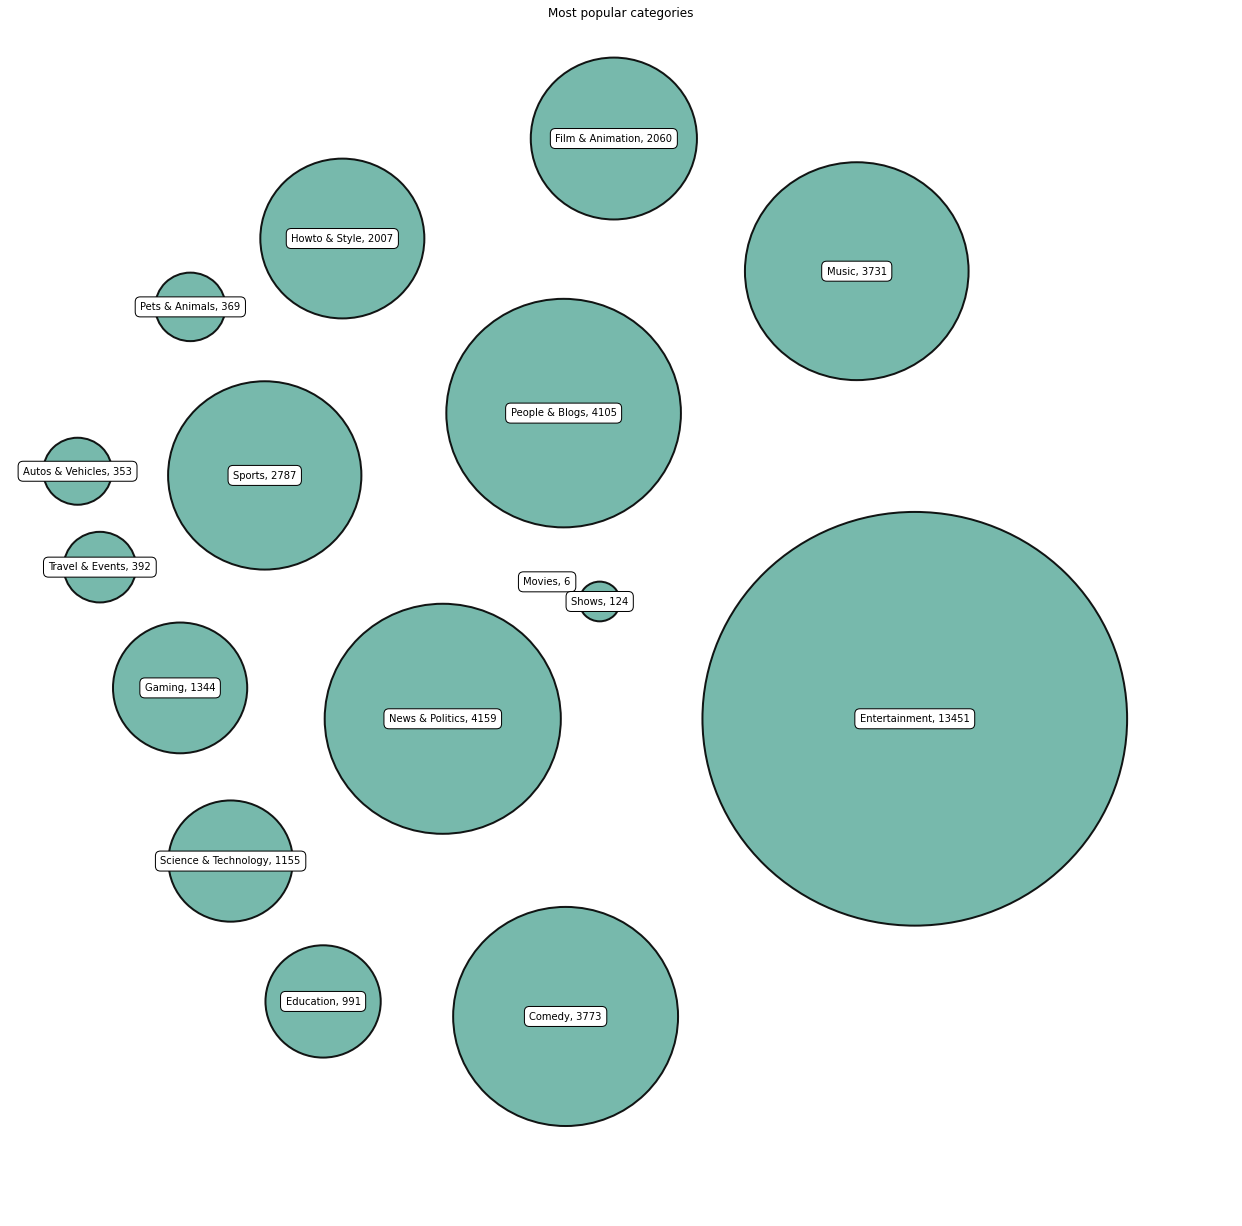

In [16]:
# compute circle positions:
circles = circlify.circlify(
    list_of_values, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(22,22))

# Title
ax.set_title('Most popular categories')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = combined

# print circles
for circle, label in zip(circles, labels):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r*0.7, alpha=0.9, linewidth=2, facecolor="#69b2a3", edgecolor="black"))
    plt.annotate(label, (x,y ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5))


### Distribution of categories
The chart above is presenting how many times videos were tied to specific category. As we can see the most common category is **Entertainment**.

In [17]:
# format tags - remove quotas and convert it into lists 
df['tags_list'] = df['tags'].str.replace('"','').str.lower().str.split('|')

# create big list with all tags lists -> list = [list1,list2,list3,...]
tags = df['tags_list'].tolist()

# convert it to flat list: [list1,list2,list3,...] -> [list1_elements, list2_elements, ..] i.e. [[1,2,3],[4,5]] -> [1,2,3,4,5]
tags = list(itertools.chain(*tags))

In [18]:
# get 20 tags that are the most common
top_20_tags = Counter(tags).most_common()[:20]

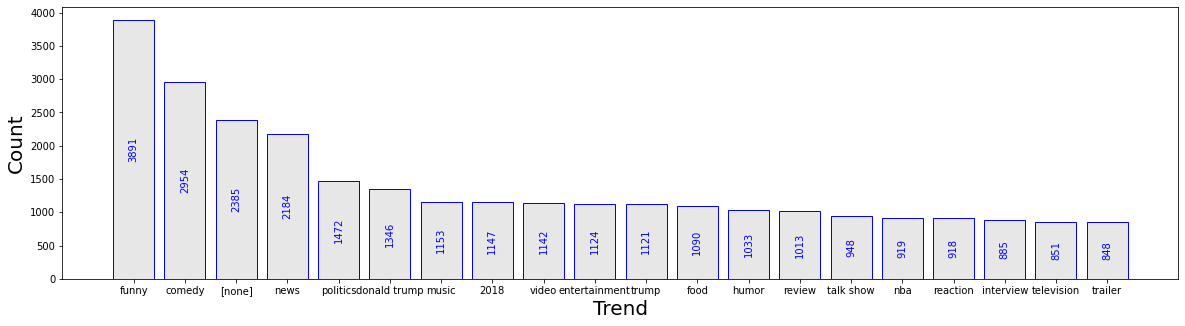

In [19]:
# create a dataset
bars = [tag[0] for tag in top_20_tags]
height = [tag[1] for tag in top_20_tags]
x_pos = np.arange(len(bars))

fig, ax = plt.subplots()    
# Create bars with blue edge color
plt.bar(x_pos, height, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')

# Add value to the bar
ax.bar_label(ax.containers[0], label_type='center', rotation=90, color='blue')

# Create names on the x-axis
plt.xticks(x_pos, bars)

ax.set_xlabel("Trend",fontsize=20)
ax.set_ylabel("Count",fontsize=20)

# Show chart
plt.gcf().set_size_inches(20, 5);

### Distirbution of tags
After separeting tags, we can conclude that most of videos are treated as funny/comedy (top 2 most common tags). Interesting thing is that almost 2400 videos are labeld with 0 tags.

In [20]:
df['likes/dislikes'] = df['likes']/df['dislikes']
temp_df = df[['category','likes/dislikes']]

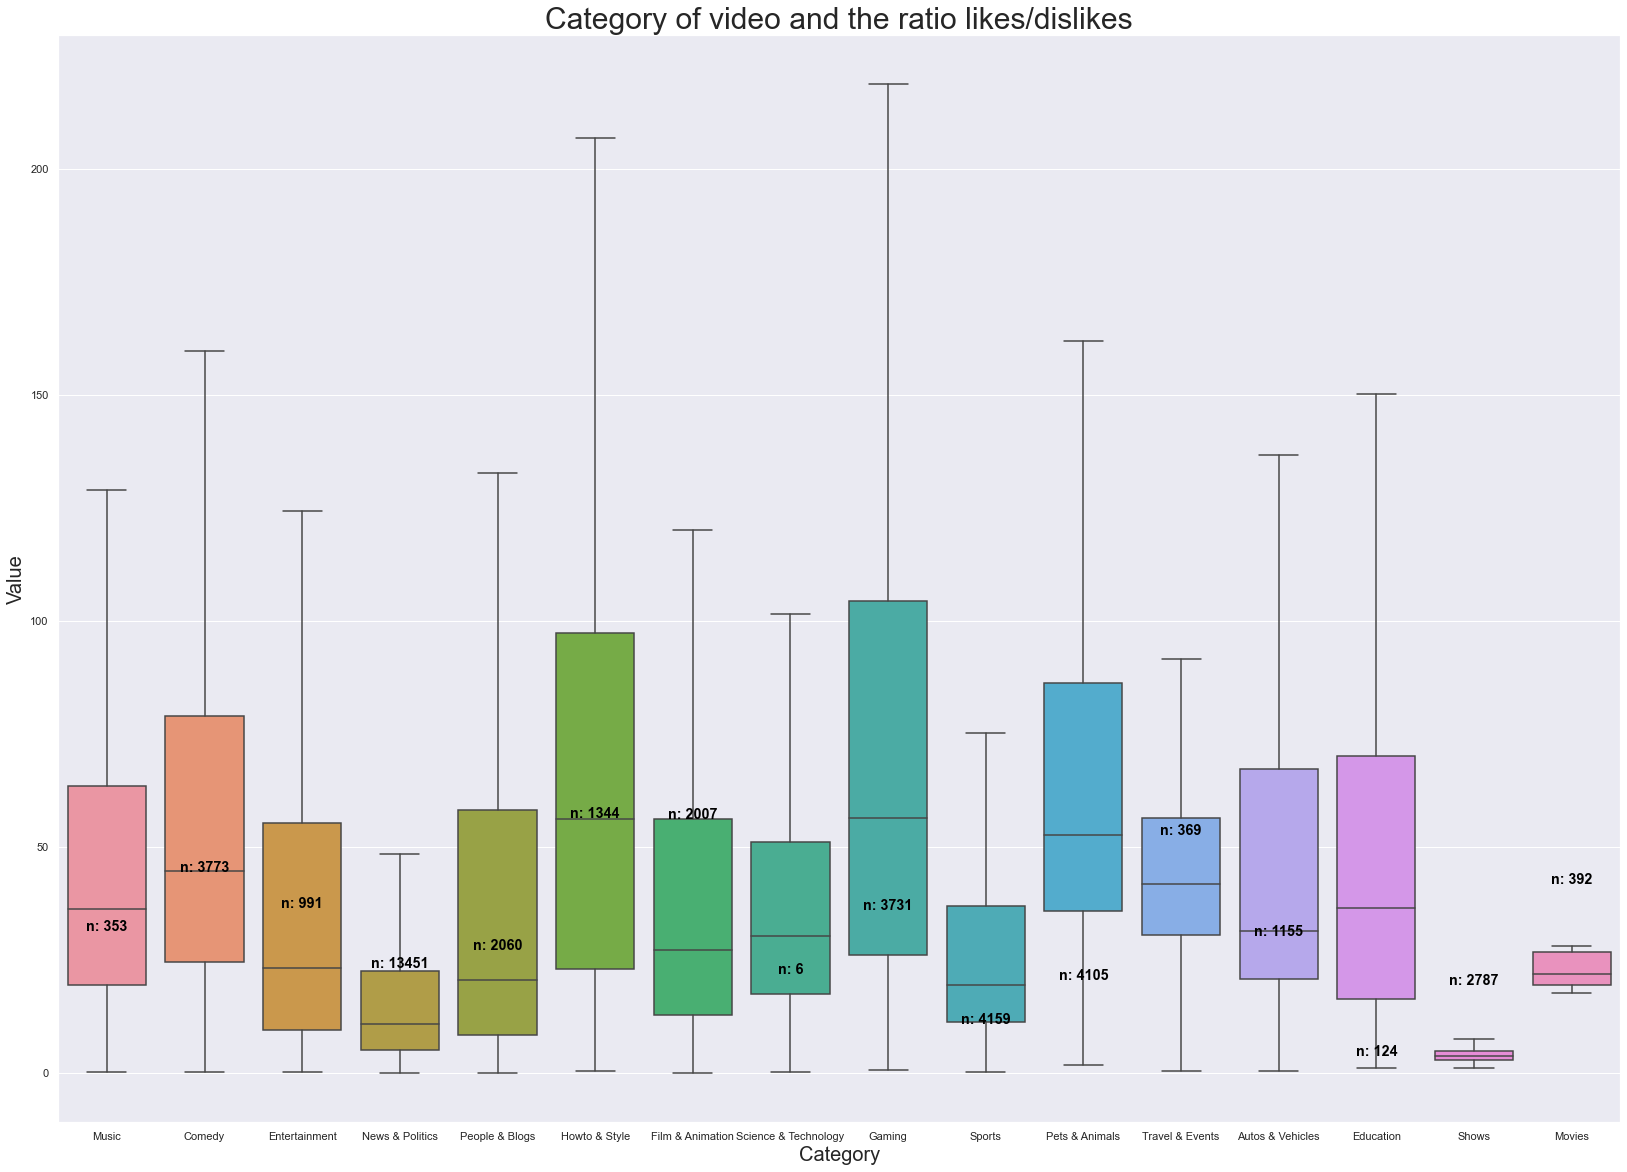

In [47]:
# create seaborn chart
sns.set(rc={'figure.figsize':(28,20)})

ax = sns.boxplot(x='category', y='likes/dislikes', data=temp_df, showfliers=False)

medians = df.groupby(['category'])['likes/dislikes'].median().values
nobs = df.groupby("category").size().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# Add it to the plot
pos = range(len(nobs))

for tick,label in zip(pos,ax.get_xticklabels()):
    plt.text(pos[tick], medians[tick], nobs[tick], horizontalalignment='center', size='large', color='black', weight='bold')

# add title
ax.axes.set_title("Category of video and the ratio likes/dislikes",fontsize=30)
ax.set_xlabel("Category",fontsize=20)
ax.set_ylabel("Value",fontsize=20);

### Distribution of ratio between likes and dislikes for each category
As we can observe the favorite category is Gaming and Howto & Style, the least liked category is Shows.

In [22]:
# change format of publish_time and trending_date
df['publish_time'] = pd.to_datetime(df['publish_time'].astype('datetime64[ns]').dt.strftime('%d/%m/%Y'), format="%d/%m/%Y")
df['trending_date'] = pd.to_datetime(pd.to_datetime(df['trending_date'], format="%y.%d.%m").dt.strftime('%d/%m/%Y'), format="%d/%m/%Y")

In [23]:
# create column with number of days that video needed to become trend
df['time_to_trend'] = (df['trending_date'] - df['publish_time']).dt.days

#create column with publish date in format MMYYYY
df['publish_month'] = pd.to_datetime(df['publish_time'], format='%YYYY-%m-%d').dt.month 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ How many days video needed to become popular over categories                           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                       1 day  2 day  3-5 days  6-10 days  11-30 days  more than 30 days │
│ Autos & Vehicles        219     89        21          6           2                  2 │
│ Comedy                 1669   1120       764         29           7                 18 │
│ Education               511    294       152          8           5                  3 │
│ Entertainment          7064   3493      2280         90          32                 13 │
│ Film & Animation        942    552       472         34           3                 11 │
│ Gaming                  606    384       244          9           2                  1 │
│ Howto & Style          1084    548       283          5           7                  1 │
│ Movies                    1      1         3          0           0                  0 │
│ Music                  1236   1019      1206        102          52                  8 │
│ News & Politics        2272   1038       468         23           6                  2 │
│ People & Blogs         2055   1063       714         41          18                 15 │
│ Pets & Animals          184    115        55          5           5                  0 │
│ Science & Technology    566    325       194         15           4                  4 │
│ Shows                    94     26         3          0           0                  0 │
│ Sports                 1528    575       259         14           6                  5 │
│ Travel & Events         176    144        59          0           3                  0 │
└────────────────────────────────────────────────────────────────────────────────────────┘

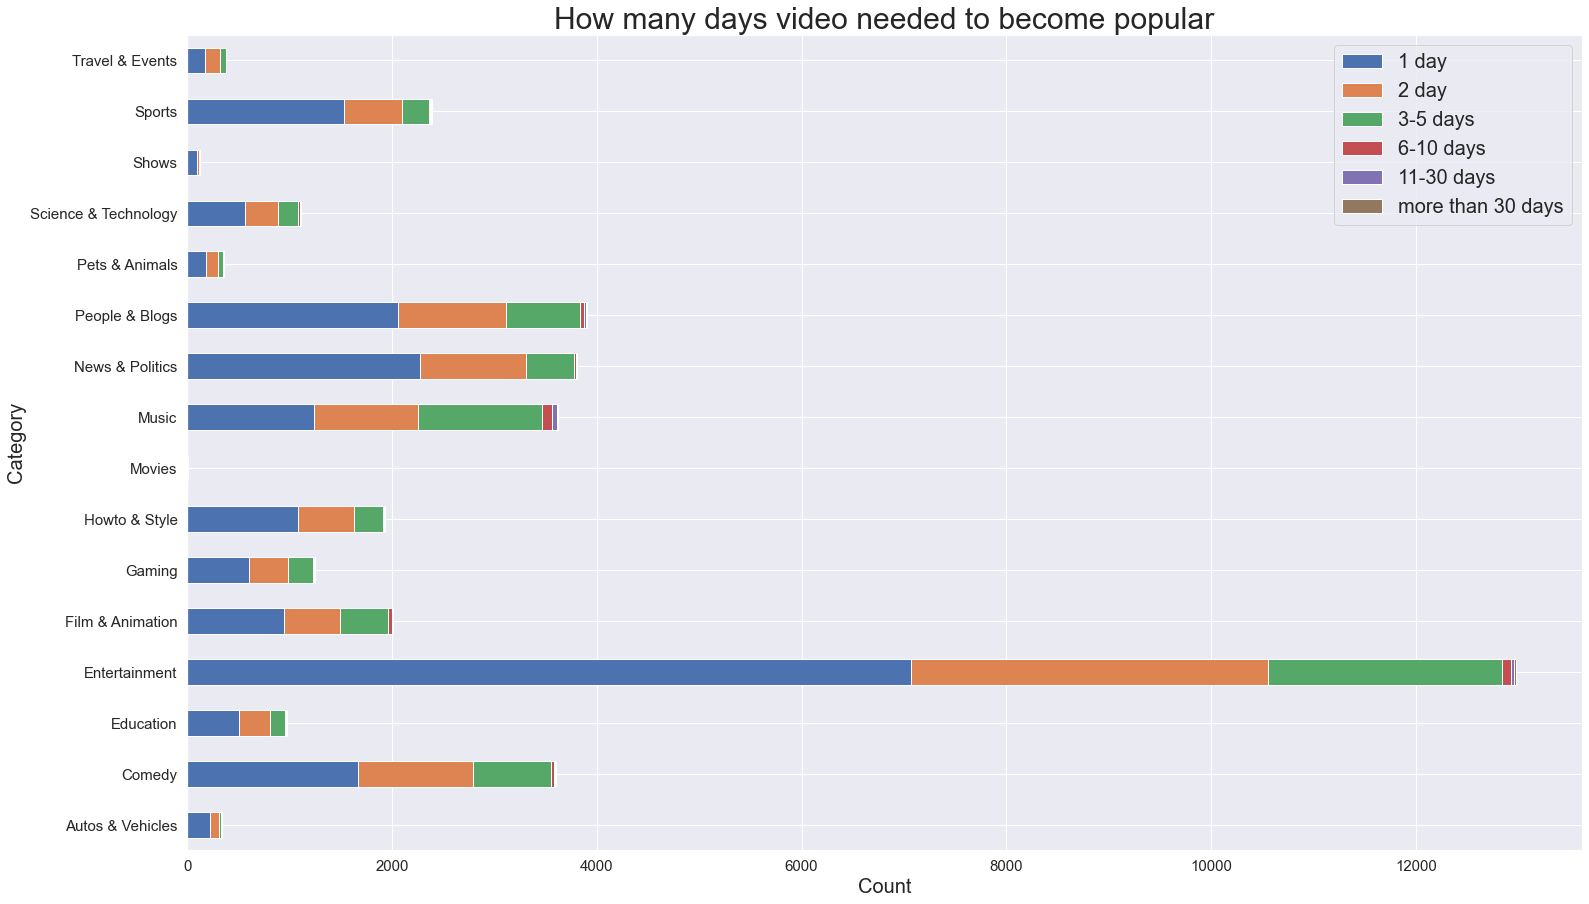

In [43]:
list_of_cols = ["1 day", "2 day", "3-5 days", "6-10 days", "11-30 days", "more than 30 days"] 

# create bins for column time_to_trend
bins = [0, 1, 2, 5, 10, 30, float("inf")]
df_time_to_trend = df[['category','time_to_trend']].groupby(['category', pd.cut(df.time_to_trend, bins)]).size().unstack()
df_time_to_trend.columns = df_time_to_trend.columns.astype(str)

# rename columns
for col in range(0,len(df_time_to_trend.columns)):
    df_time_to_trend.columns.values[col] = list_of_cols[col]

# remove index names
df_time_to_trend = df_time_to_trend.rename_axis(None, axis=1)
df_time_to_trend = df_time_to_trend.rename_axis(None, axis=0)

# create chart with stacked bars
ax = df_time_to_trend.plot.barh(stacked=True, figsize=(25, 15))

# format legend
ax.legend(list_of_cols, fontsize=20)
# format size of ticks
ax.tick_params(axis='both', labelsize=15)

# change title and labels
ax.axes.set_title('How many days video needed to become popular',fontsize=30)
ax.set_xlabel("Count",fontsize=20)
ax.set_ylabel("Category",fontsize=20);

# print table with data as well
pretty_table(df_time_to_trend, 'How many days video needed to become popular over categories')

In [25]:
numerical_cols = list(df.select_dtypes([np.number]).columns)
categorical_cols = list(set(df.columns) - set(numerical_cols))